In [1]:
import math # importe un package
import numpy as np # importe un package sous un nom particulier
from sklearn import linear_model # importe tout un module
import scipy
import matplotlib.pyplot as plt
import os
import pandas as pd
import urllib
import zipfile
import sys
import statsmodels.api as sm
import pylab as py
import seaborn as sns
np.random.seed(0)

# Data cleaning

In [2]:
df=pd.read_csv('KaggleV2-May-2016.csv')
print(df.info())
print("This dataframe is duplicated ? {}".format(df.duplicated().sum()))
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None
This dataframe is duplicated ? 0


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


According to these information, we find that there is no NULL values, so we don't need to remove NULL values.There is no duplicated rows, so we do not need to remove them.

We also notice that data types are different. Therefore, we need to do as follows: 
1. To be consistent with other Bool columns, we make Gender = 0 for female,1 for male; no show = 0 for show, 1 for no show; 
2. ID need to be expressed as a string for future searching.
3. Date need to be transformed into datetime64


In [7]:
df_new = df.copy() #Copy this dataframe

df_new['No-show'].replace(['Yes', 'No'], [0,1],inplace=True) #No means no show, Yes means show
#改名字
df_new['Gender'].replace(['F', 'M'], [0,1],inplace=True)

df_new['PatientId'] = df_new['PatientId'].astype(str)
df_new['AppointmentID'] = df_new['AppointmentID'].astype(str)

df_new['ScheduledDay'] = pd.to_datetime(df_new['ScheduledDay'])
df_new['AppointmentDay'] = pd.to_datetime(df_new['AppointmentDay'])
#变成差 scheduledDay-AppointmentDay 变成float
difference = pd.DataFrame(df_new['AppointmentDay']-df_new['ScheduledDay'],columns=['AvanceDate'])
df_new = pd.concat([df_new,difference], axis=1,sort=False)
df_new = df_new.drop(df_new[df_new['AvanceDate'] < pd.Timedelta(0)].index)

#把neighbor改成label
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
encoder = LabelEncoder()  
label = encoder.fit_transform(df_new['Neighbourhood'].values)  
label = np.array([label]).T
label_df = pd.DataFrame(label,columns=['Neighbourhood'])

enc = OneHotEncoder()
a=enc.fit_transform(label_df)
a=a.toarray()
df_new = pd.concat([df_new,pd.DataFrame(a)],axis=1)
df_new = df_new.drop(['Neighbourhood'],axis=1)

#df_new = pd.concat([df_new.drop(['Neighbourhood'],axis = 1, inplace = False),label_df], axis=1,sort=False)
#new_num = df_new.select_dtypes(include=np.number)
#new_num.fillna(0.0, inplace=True)

df_new.dropna(how = 'any',inplace = True)
df_new

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,...,70,71,72,73,74,75,76,77,78,79
5,95985133231274.0,5626772,0.0,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,733688164476661.0,5630279,0.0,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3449833394123.0,5630575,0.0,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,78124564369297.0,5629123,0.0,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,734536231958495.0,5630213,0.0,2016-04-27 14:58:11+00:00,2016-04-29 00:00:00+00:00,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71953,1538795186117.0,5655248,0.0,2016-05-03 16:25:29+00:00,2016-05-06 00:00:00+00:00,21.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71954,946267896512353.0,5691561,0.0,2016-05-12 13:12:23+00:00,2016-05-13 00:00:00+00:00,39.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71955,1538795186117.0,5671393,0.0,2016-05-06 16:47:09+00:00,2016-05-20 00:00:00+00:00,21.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71956,9723486469886.0,5667268,0.0,2016-05-06 07:34:35+00:00,2016-05-13 00:00:00+00:00,46.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data Normalization

We need to normalize the Age column. For the other columns with dtype=int, since they are already normalized into [0,1], so the result does not change

In [29]:
df_std = df_new.copy()
for i in ["Gender","Age","Scholarship","Hipertension","Diabetes","Alcoholism","Handcap","SMS_received","No-show"]: 
    df_std[i] = (df_new[i] - df_new[i].min())/(df_new[i].max()-df_new[i].min())
df_std.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296.0,5642903,0.0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,0.543103,JARDIM DA PENHA,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,558997776694438.0,5642503,1.0,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,0.491379,JARDIM DA PENHA,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,4262962299951.0,5642549,0.0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,0.543103,MATA DA PRAIA,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,867951213174.0,5642828,0.0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,0.077586,PONTAL DE CAMBURI,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8841186448183.0,5642494,0.0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,0.491379,JARDIM DA PENHA,0.0,1.0,1.0,0.0,0.0,0.0,1.0


We want to divide our whole dataset into two parts: Training set and Testing set. 

We choose the first 100000 records for training our model, and the rest 10000 records for testing. In the following research, all results analyzed are based on training set. 

In [30]:
train = df_new[:100000]
test = df_new[100000:]

# Initial analyzing

We would like to do some preliminary analysis of the data. In the following, we will intuitively analyze the factors that influence medical appointment attendance

### Correlation

<AxesSubplot:>

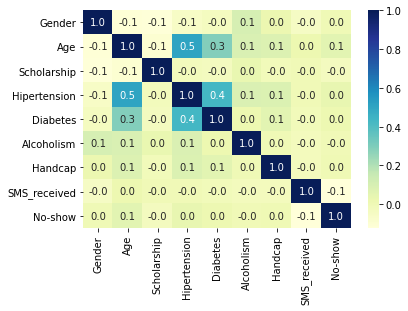

In [31]:
corr = train.corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,cmap="YlGnBu", annot = True, fmt = '.1f')

We found that
1. Diabetes and hipertensions seem to be correlated, and both of them are correlated with age. It corresponds to the reality. 
2. There is no obvious factor that is strongly positive or negative correlated to the No-show problem. However, it seems that age is slightly positive correlated with no-show, and SMS received rate is negative related to no show problem.


### Gender

In [6]:
df_new[df_new['Gender'] == 1]['No-show'].mean()
df_new[df_new['Gender'] == 0]['No-show'].mean()

0.7968541202672605

### Age

In [18]:
np.sum( df_new['Age'] * df_new['No-show'] )/df_new.size

2.1542157119979732

# Find out the most important factor